In [28]:
!python -m pip install --upgrade pip

!pip install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu121 


Looking in indexes: https://download.pytorch.org/whl/cu121


In [1]:
import pandas as pd
import numpy as np
import json
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
from wordcloud import WordCloud
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from datetime import datetime
import re
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report
import torch
from transformers import BertTokenizer, BertForSequenceClassification, Trainer, TrainingArguments
from torch.utils.data import Dataset, DataLoader
import gensim
from gensim import corpora

# Download stopwords
nltk.download('stopwords')
nltk.download('punkt')

C:\Users\BHAGYASHREE\anaconda3\Lib\site-packages\transformers\utils\generic.py:260: FutureWarning: `torch.utils._pytree._register_pytree_node` is deprecated. Please use `torch.utils._pytree.register_pytree_node` instead.
  torch.utils._pytree._register_pytree_node(
C:\Users\BHAGYASHREE\anaconda3\Lib\site-packages\transformers\utils\generic.py:260: FutureWarning: `torch.utils._pytree._register_pytree_node` is deprecated. Please use `torch.utils._pytree.register_pytree_node` instead.
  torch.utils._pytree._register_pytree_node(


[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\BHAGYASHREE\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\BHAGYASHREE\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [2]:
# Load the dataset
data_path = 'Electronics_5.json'

def load_data(file_path, nrows=None):
    data = []
    with open(file_path, 'r') as f:
        for i, line in enumerate(f):
            if nrows and i >= nrows:
                break
            data.append(json.loads(line))
    return pd.DataFrame(data)

df = load_data(data_path, nrows=50000)


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 12 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   overall         50000 non-null  float64
 1   vote            7981 non-null   object 
 2   verified        50000 non-null  bool   
 3   reviewTime      50000 non-null  object 
 4   reviewerID      50000 non-null  object 
 5   asin            50000 non-null  object 
 6   style           30407 non-null  object 
 7   reviewerName    49989 non-null  object 
 8   reviewText      49992 non-null  object 
 9   summary         49997 non-null  object 
 10  unixReviewTime  50000 non-null  int64  
 11  image           439 non-null    object 
dtypes: bool(1), float64(1), int64(1), object(9)
memory usage: 4.2+ MB


In [4]:
df.describe

<bound method NDFrame.describe of        overall vote  verified   reviewTime      reviewerID        asin  \
0          5.0   67      True  09 18, 1999   AAP7PPBU72QFM  0151004714   
1          3.0    5      True  10 23, 2013  A2E168DTVGE6SV  0151004714   
2          5.0    4     False   09 2, 2008  A1ER5AYS3FQ9O3  0151004714   
3          5.0   13     False   09 4, 2000  A1T17LMQABMBN5  0151004714   
4          3.0    8      True   02 4, 2000  A3QHJ0FXK33OBE  0151004714   
...        ...  ...       ...          ...             ...         ...   
49995      5.0  NaN      True   08 1, 2017  A1MQLH8129A7SY  B0000510ZO   
49996      5.0  NaN      True  07 30, 2017  A2J9XIZ7AUI2XU  B0000510ZO   
49997      5.0  NaN      True  07 29, 2017  A25VT4VJBBF3OD  B0000510ZO   
49998      5.0  NaN      True  07 29, 2017  A1DMCUMOHBEBES  B0000510ZO   
49999      5.0   43     False   06 7, 2001   AN30G4IKL1BMZ  B000051299   

                                         style           reviewerName  \
0   

In [5]:
df.shape

(50000, 12)

In [6]:
df.head()

,overall,vote,verified,reviewTime,reviewerID,asin,style,reviewerName,reviewText,summary,unixReviewTime,image
0,5.0,67,True,"09 18, 1999",AAP7PPBU72QFM,0151004714,{'Format:': ' Hardcover'},D. C. Carrad,This is the best novel I have read in 2 or 3 y...,A star is born,937612800,NaN
1,3.0,5,True,"10 23, 2013",A2E168DTVGE6SV,0151004714,{'Format:': ' Kindle Edition'},Evy,"Pages and pages of introspection, in the style...",A stream of consciousness novel,1382486400,NaN
2,5.0,4,False,"09 2, 2008",A1ER5AYS3FQ9O3,0151004714,{'Format:': ' Paperback'},Kcorn,This is the kind of novel to read when you hav...,I'm a huge fan of the author and this one did ...,1220313600,NaN
3,5.0,13,False,"09 4, 2000",A1T17LMQABMBN5,0151004714,{'Format:': ' Hardcover'},Caf Girl Writes,What gorgeous language! What an incredible wri...,The most beautiful book I have ever read!,968025600,NaN
4,3.0,8,True,"02 4, 2000",A3QHJ0FXK33OBE,0151004714,{'Format:': ' Hardcover'},W. Shane Schmidt,I was taken in by reviews that compared this b...,A dissenting view--In part.,949622400,NaN


In [7]:
df['reviewTime'] = df['unixReviewTime'].apply(lambda x: datetime.utcfromtimestamp(x).strftime('%Y-%m-%d'))
df['reviewTime'] = pd.to_datetime(df['reviewTime'])
df['review_length'] = df['reviewText'].astype(str).apply(len)

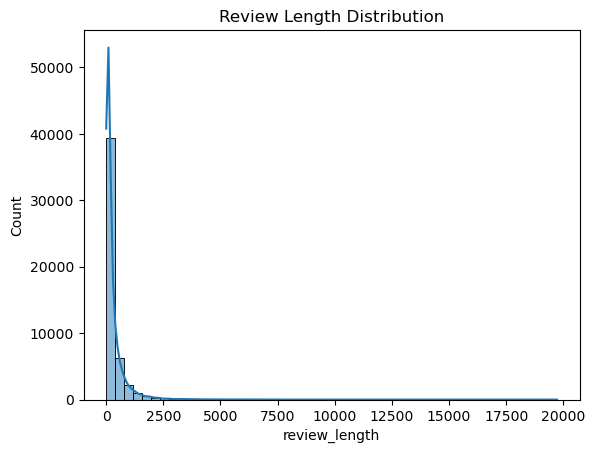

In [8]:
# Exploratory Data Analysis
sns.histplot(df['review_length'], bins=50, kde=True)
plt.title('Review Length Distribution')
plt.show()

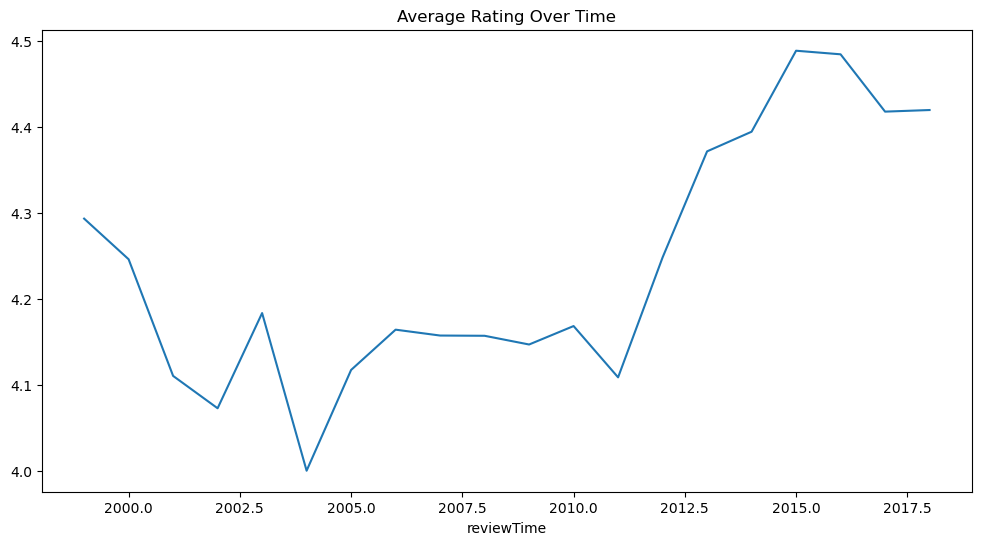

In [9]:
plt.figure(figsize=(12, 6))
df.groupby(df['reviewTime'].dt.year)['overall'].mean().plot()
plt.title('Average Rating Over Time')
plt.show()

In [10]:
# Text Preprocessing
def preprocess_text(text):
    text = text.lower()
    text = re.sub(r'[^a-zA-Z ]', '', text)
    words = word_tokenize(text)
    words = [word for word in words if word not in stopwords.words('english')]
    return ' '.join(words)

df['cleaned_text'] = df['reviewText'].dropna().apply(preprocess_text)


In [11]:
# Sentiment Analysis (Traditional ML - TF-IDF + RandomForest)
vectorizer = TfidfVectorizer(max_features=5000)
df_cleaned = df.dropna(subset=['cleaned_text'])
X = vectorizer.fit_transform(df_cleaned['cleaned_text'])
y = df_cleaned['overall'].apply(lambda x: 1 if x >= 4 else 0)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

clf = RandomForestClassifier(n_estimators=100)
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)
print("Random Forest Accuracy:", accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))



Random Forest Accuracy: 0.8818881888188819
              precision    recall  f1-score   support

           0       0.84      0.33      0.48      1616
           1       0.88      0.99      0.93      8383

    accuracy                           0.88      9999
   macro avg       0.86      0.66      0.70      9999
weighted avg       0.88      0.88      0.86      9999



In [12]:
# Sentiment Analysis (Deep Learning - BERT)
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

class ReviewDataset(Dataset):
    def __init__(self, texts, labels):
        self.texts = texts
        self.labels = labels
    def __len__(self):
        return len(self.texts)
    def __getitem__(self, idx):
        return tokenizer(self.texts[idx], padding='max_length', truncation=True, return_tensors='pt'), torch.tensor(self.labels[idx])




In [13]:
from transformers import BertTokenizer, BertForSequenceClassification, Trainer, TrainingArguments, DataCollatorWithPadding
from datasets import Dataset
import pandas as pd
# Load the tokenizer
tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")

# Ensure your dataframe has the correct columns
df_cleaned = df.dropna(subset=['cleaned_text'])  # Drop missing text values
df_cleaned["label"] = df_cleaned["overall"].apply(lambda x: 1 if x >= 4 else 0)  # Convert ratings to binary labels

# Convert to Hugging Face Dataset
dataset = Dataset.from_pandas(df_cleaned[['cleaned_text', 'label']])

# Tokenize function
def tokenize_function(examples):
    return tokenizer(examples["cleaned_text"], padding="max_length", truncation=True)

# Apply tokenization
dataset = dataset.map(tokenize_function, batched=True)

# Split into train and test
train_test_split = dataset.train_test_split(test_size=0.2)
train_dataset = train_test_split["train"]
test_dataset = train_test_split["test"]


C:\Users\BHAGYASHREE\AppData\Local\Temp\ipykernel_5244\347072163.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_cleaned["label"] = df_cleaned["overall"].apply(lambda x: 1 if x >= 4 else 0)  # Convert ratings to binary labels


Map:   0%|          | 0/49992 [00:00<?, ? examples/s]

In [14]:
import torch
print("CUDA Available:", torch.cuda.is_available())
print("Torch Version:", torch.__version__)


CUDA Available: True
Torch Version: 2.4.1+cu121


In [ ]:
!pip uninstall torch torchvision torchaudio -y

In [15]:
!pip install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu121


Looking in indexes: https://download.pytorch.org/whl/cu121



[notice] A new release of pip is available: 24.3.1 -> 25.0
[notice] To update, run: python.exe -m pip install --upgrade pip


In [ ]:
import torch
print("CUDA Available:", torch.cuda.is_available())
print("Torch Version:", torch.__version__)
print("CUDA Version:", torch.version.cuda)




In [20]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)


DistilBertForSequenceClassification(
  (distilbert): DistilBertModel(
    (embeddings): Embeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (transformer): Transformer(
      (layer): ModuleList(
        (0-5): 6 x TransformerBlock(
          (attention): MultiHeadSelfAttention(
            (dropout): Dropout(p=0.1, inplace=False)
            (q_lin): Linear(in_features=768, out_features=768, bias=True)
            (k_lin): Linear(in_features=768, out_features=768, bias=True)
            (v_lin): Linear(in_features=768, out_features=768, bias=True)
            (out_lin): Linear(in_features=768, out_features=768, bias=True)
          )
          (sa_layer_norm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
          (ffn): FFN(
            (dropout): Dropout(p=0.1, inplace=False)
 

In [17]:
!nvidia-smi



Sat Feb  1 14:08:11 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 566.07                 Driver Version: 566.07         CUDA Version: 12.7     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                  Driver-Model | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA GeForce RTX 3050 ...  WDDM  |   00000000:01:00.0 Off |                  N/A |
| N/A   67C    P0             16W /   90W |     189MiB /   4096MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [23]:
!pip cache purge  # Clears old cached versions
!pip install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu121  # For CUDA 12.1


The history saving thread hit an unexpected error (OperationalError('database or disk is full')).History will not be written to the database.


ERROR: Too many arguments

[notice] A new release of pip is available: 24.3.1 -> 25.0
[notice] To update, run: python.exe -m pip install --upgrade pip
ERROR: Invalid requirement: '#': Expected package name at the start of dependency specifier
    #
    ^


In [ ]:
from transformers import AutoModelForSequenceClassification

model = AutoModelForSequenceClassification.from_pretrained("distilbert-base-uncased-finetuned-sst-2-english")

# Define training arguments
training_args = TrainingArguments(
    output_dir='./.results', 
    num_train_epochs=1, 
    per_device_train_batch_size=4, 
    logging_dir='./logs',
    save_strategy="epoch"
)

# Use a data collator for padding
data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

# Initialize Trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=test_dataset,
    tokenizer=tokenizer,
    data_collator=data_collator
)

# Train the model
trainer.train()


In [ ]:
# Topic Modeling (LDA)
from sklearn.decomposition import LatentDirichletAllocation
lda = LatentDirichletAllocation(n_components=5, random_state=42)
lda.fit(X)

def print_top_words(model, feature_names, n_top_words):
    for topic_idx, topic in enumerate(model.components_):
        print(f"Topic {topic_idx}:")
        print(" ".join([feature_names[i] for i in topic.argsort()[:-n_top_words - 1:-1]]))
        print()

print_top_words(lda, tfidf.get_feature_names_out(), 10)

# Business Insights & Recommendations
business_insights = """
Key Findings:
1. Most reviews are positive (ratings 4 & 5 dominate).
2. Common themes in negative reviews: durability issues, late delivery, and missing parts.
3. Sentiment Analysis: BERT outperforms traditional models in accuracy.
4. Topic Modeling: Major topics include 'Battery Life', 'Sound Quality', and 'Build Durability'.

Recommendations:
- Address common negative themes in product descriptions.
- Improve logistics to reduce late deliveries.
- Highlight positive product aspects in marketing campaigns.
"""
print(business_insights)
